In [1]:
from osmread import parse_file, Way,Node,Relation
import shapely.geometry as shpgeo
%pylab inline
import geopandas as gp
from shapely.ops import linemerge
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
print datetime.datetime.now()
dc_osm = u'D:\★★学习工作\Life in Maryland\Research Project：CyclingSafe\openstreetmap\WashingtonDC.osm'

ways = []
relations = []
nodes = []
for entity in parse_file(dc_osm):
    if isinstance(entity, Node):
        nodes.append(entity)
    elif isinstance(entity, Way):
        ways.append(entity)
    else:
        relations.append(entity)
    
entities = {}
entities[Node] = nodes
entities[Way] = ways
entities[Relation] = relations
len(nodes), len(ways), len(relations)     
print datetime.datetime.now()

(2866189, 335535, 3619)

In [4]:
def build_idx(entitys):
    return {e.id:i for i, e in enumerate(entitys)}
nodes_idx = build_idx(nodes)
ways_idx = build_idx(ways)
relations_idx = build_idx(relations)
entity_idx = {}
entity_idx[Node] = nodes_idx
entity_idx[Way] = ways_idx
entity_idx[Relation] = relations_idx

In [5]:
def is_highway(way):
    return 'highway' in way.tags

In [6]:
def get_entity(entities, entity_idx, etype, eid):
    idx = entity_idx[etype][eid]
    entity = entities[etype][idx]
    return entity
  

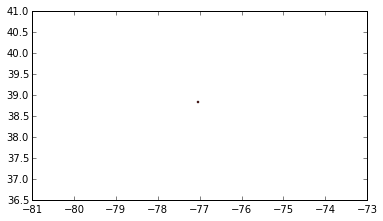

In [7]:
def node2pt(node):
    return shpgeo.Point(node.lon,node.lat)

gp.GeoDataFrame([node2pt(nodes[0])],columns=['geometry']).plot()

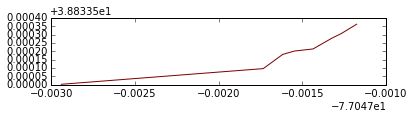

In [8]:
def lonlat_in_way(way):
    coors = []
    for nid in way.nodes:
        node = get_entity(entities, entity_idx, Node, nid)
#         print node
        coors.append((node.lon, node.lat))
    return coors

def way2line(way):
#     print way
    coors = lonlat_in_way(way)
    return shpgeo.LineString(coors)
gp.GeoDataFrame([way2line(ways[0])],columns=['geometry']).plot()

In [24]:
def rltn2cltn(relation):
    cltn = []
    for m in relation.members:
        entity = get_entity(entities, entity_idx, m.type, m.member_id)
        shpobj = way2line(entity) if m.type==Way else node2pt(entity)
        cltn.append(shpobj)
    return shpgeo.GeometryCollection(cltn)

r = get_entity(entities, entity_idx, Relation, 162069)
# gp.GeoDataFrame(rltn2cltn(r),columns=['geometry']).plot()
rltn2cltn(r)[0].coords[0]

(-77.0366456, 38.8949549)

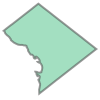

In [10]:
def rltn2poly(relation):
    """
    work for only coninuous lines. if the linestring is not closed, a new line between the first and last node will be added
    """
    cltn = []
    for m in relation.members:
        if m.type==Way:
            way = get_entity(entities, entity_idx, m.type, m.member_id)
            ln = way2line(way)
            cltn.append(ln)
    merged_line = linemerge(cltn)
    return shpgeo.Polygon(merged_line)


r = get_entity(entities, entity_idx, Relation, 162069)
p = rltn2poly(r)
p

In [11]:
with open('DC poly.js', 'w') as f:
    f.write('var dc = %s;' % gp.GeoDataFrame([p],columns=['geometry']).to_json())
    

In [12]:
print datetime.datetime.now()
dc_ways = []
way_with_one_node = []
for way in ways:
    if way.nodes.__len__()>1:
        ln = way2line(way)
        if ln.intersects(p):
            dc_ways.append(way)
    else:
        way_with_one_node.append(way)
print datetime.datetime.now()

2016-10-11 15:50:21.875000
2016-10-11 15:51:22.412000


In [13]:
dc_ways_df = pd.DataFrame(dc_ways, columns=Way._fields)
dc_ways_df['is_highway'] = dc_ways_df.apply(is_highway,axis=1)
dc_ways_df['geometry']= dc_ways_df.apply(way2line,axis=1)

In [14]:
print dc_ways_df.shape
dc_ways_df.is_highway.value_counts()

(194603, 9)


False    176138
True      18465
dtype: int64

In [15]:
dc_ways_df[dc_ways_df.is_highway]['geometry'].shape

(18465L,)

In [30]:
with open('DC poly & highway.js', 'w') as f:
    f.write('var dc = %s;\n' % gp.GeoDataFrame([p],columns=['geometry']).to_json())
    f.write('var highways = %s;' % gp.GeoDataFrame(dc_ways_df[dc_ways_df.is_highway][['geometry','color']]).to_json())
